In [1]:
# Imports
%matplotlib inline

import sys
import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots
from sklearn.metrics import accuracy_score, classification_report

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [2]:
def create_sort_dataset(dataset_length, seq_length, max_number=999):
    x_train = np.random.randint(low=0, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_train = np.sort(x_train, axis=1)
    
    x_test = np.random.randint(low=0, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_test = np.sort(x_test, axis=1)
    
    return x_train, y_train, x_test, y_test

def create_dummy_dataset(dataset_length, seq_length, max_number):
    lower_bound = -1 * max_number
    x_train = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_train = np.where(x_train.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    x_test = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_test = np.where(x_test.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    return x_train, y_train, x_test, y_test
    

In [3]:
# Define the linear tensor transformation layer
class TensorLinear(object):
    """The linear tensor layer applies a linear tensor dot product 
    and a bias to its input."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Initialse the weight W and bias b parameters."""
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        # Axes summed over in backprop
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Perform forward step transformation with the help 
        of a tensor product."""
        # Same as: Y[i,j,:] = np.dot(X[i,j,:], self.W) + self.b 
        #          (for i,j in X.shape[0:1])
        # Same as: Y = np.einsum('ijk,kl->ijl', X, self.W) + self.b
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:]) 
        #          (for i,j in X.shape[0:1])
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T) 
        #          (for i,j in gY.shape[0:1])
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

# Define the logistic classifier layer
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its 
    inputs."""
   
    def forward(self, X):
        """Perform the forward step transformation."""
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y, T):
        """Return the gradient with respect to the loss function 
        at the inputs of this layer."""
        # Average by the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        """Compute the loss at the output."""
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))

class LogisticClassifierSoftmax:
    def forward(self, X, theta = 1.0, axis = 2):
        "Takes X as 3d tensor"

        # multiply y against the theta parameter,
        y = X * float(theta)
        # subtract the max for numerical stability
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        # exponentiate y
        y = np.exp(y)
        # take the sum along the specified axis
        ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
        # finally: divide elementwise
        return y / ax_sum
        
    def loss(self, Y, T):
        """
        Y is the output from fully connected layer passed through softmax (batch_size x num_examples x num_classes)
        T is labels (batch_size x num_examples x 1)
            Note that y is not one-hot encoded vector. 
            It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
        """
#         print(f"Y.shape {Y.shape}")
#         print(f"T.shape {T.shape}")
        m = T.shape[1]
        #ps = self.forward(Y, axis=2)

        losses = []
        for idx, p in enumerate(Y):  
            log_likelihood = -np.log(p[range(m), T[idx].flatten()])
            loss = np.sum(log_likelihood) / m
            losses.append(loss)
        return np.mean(losses)

    def backward(self, X, T):
        """
        X is the output from fully connected layer passed through softmax (batch_size x num_examples x num_classes)
        T is labels (batch_size x num_examples x 1)
            Note that y is not one-hot encoded vector. 
            It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
        """
        delta = np.zeros(X.shape)
        m = T.shape[1]
        
        for idx in range(len(delta)):
            #x = Y[idx]
            #grad = self.forward(x, axis=1)
            #grad = x
            grad = X[idx]
            grad[range(m),T[idx].flatten()] -= 1
            grad = grad/m
            delta[idx] = grad
        return delta

# Define tanh layer
class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X):
        """Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates, W, b):
        """Initialse the linear transformation and tanh transfer 
        function."""
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates, nbTimesteps):
        """Initialse the shared parameters, the inital state and 
        state update function."""
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0 = np.zeros(nbStates)  # Initial state
        self.nbTimesteps = nbTimesteps  # Timesteps to unfold
        self.stateUpdate = RecurrentStateUpdate(
            nbStates, self.W, self.b)  # State update function
        
    def forward(self, X):
        """Iteratively apply forward step to all states."""
        # State tensor
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Initialise gradient of state outputs
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        # Initialse gradient tensor for state inputs
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state 
            #  plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        # Get gradient of initial state over all samples
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

# Define the full network
class RnnBinaryAdder(object):
    """RNN to perform binary addition of 2 numbers."""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        """Initialse the network layers."""
        # Input layer
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Recurrent layer
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Linear output transform
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifierSoftmax()  # Classification output
        #self.classifier = LogisticClassifier()  # Classification output
        self.sequence_len = sequence_len
        
    def forward(self, X):
        """Perform the forward propagation of input X through all 
        layers."""
        # Linear input transformation
        recIn = self.tensorInput.forward(X)
        # Forward propagate through time and return states
        S = self.rnnUnfold.forward(recIn)
        # Linear output transformation
        Z = self.tensorOutput.forward(S[:,1:self.sequence_len+1,:])
        Y = self.classifier.forward(Z)  # Classification probabilities
        # Return: input to recurrent layer, states, input to classifier, 
        #  output
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Perform the backward propagation through all layers.
        Input: input samples, network output, input to recurrent 
        layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:self.sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, 
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Get the output probabilities of input X."""
        recIn, S, Z, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        """Get the binary output of input X."""
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Return the gradients with respect to input X and 
        target T as a list. The list has the same order as the 
        get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        """Return the loss of input X w.r.t. targets T."""
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

In [4]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.001  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 20  # Size of the minibatches (number of samples)
max_num = 8
seq_length = 9
hidden_size = 30
nb_train = 200

x_train, y_train, x_test, y_test = create_sort_dataset(nb_train, seq_length, max_num)

input_size = 1
output_size = max_num+1

# Create the network
RNN = RnnBinaryAdder(1, max_num+1, hidden_size, seq_length)
#RNN = RnnBinaryAdder(1, output_size, hidden_size, seq_length)
# Set the initial parameters
# Number of parameters in the network
nbParameters =  sum(1 for _ in RNN.get_params_iter())
# Rmsprop moving average
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]  # Momentum

# Create a list of minibatch losses to be plotted
ls_of_loss = [
    RNN.loss(RNN.getOutput(x_train[0:mb_size]), y_train[0:mb_size])]

# Iterate over some iterations
for i in range(50):
    print(f'Epoch {i+1}')
    # Iterate over all the minibatches
    for mb in range(nb_train // mb_size):
        X_mb = x_train[mb:mb+mb_size,:,:]  # Input minibatch
        T_mb = y_train[mb:mb+mb_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        # Get gradients after following old velocity
        # Get the parameter gradients
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)    
        # Update each parameter seperately
        for pIdx, P in enumerate(RNN.get_params_iter()):
            #P -= learning_rate * backprop_grads[pIdx]
            # Update the Rmsprop moving averages
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (
                1-lmbd) * backprop_grads[pIdx]**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = ((
                learning_rate * backprop_grads[pIdx]) / np.sqrt(
                maSquare[pIdx]) + eps)
            # Update the momentum
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
            P -= pGradNorm   # Update the parameter
        # Add loss to list to plot
        ls_of_loss.append(RNN.loss(RNN.getOutput(X_mb), T_mb))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


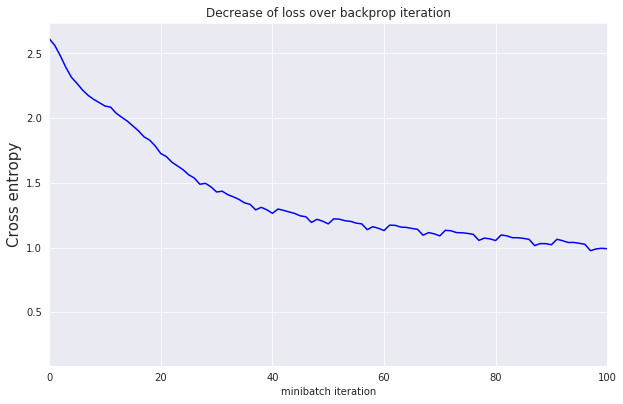

In [5]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(10, 7))
plt.plot(ls_of_loss, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('Cross entropy', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [6]:
def test_model(model, x, y):
    predictions = np.argmax(model.getOutput(x), axis=-1)
    #print(predictions)
    #print(y.squeeze())
    print(classification_report(y.squeeze().flatten(), predictions.flatten()))

In [7]:
test_model(RNN, X_mb, T_mb)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.88      0.82      0.85        17
           2       0.87      0.65      0.74        20
           3       0.80      0.89      0.84        18
           4       0.86      0.90      0.88        21
           5       0.90      1.00      0.95        18
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        17

   micro avg       0.91      0.91      0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



In [10]:
# Do gradient checking
# Define an RNN to test
RNN = RnnBinaryAdder(1, output_size, hidden_size, seq_length)
# Get the gradients of the parameters from a subset of the data
backprop_grads = RNN.getParamGrads(
    x_train[:100], y_train[:100])

eps = 1e-9  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    param += eps
    plus_loss = RNN.loss(
        RNN.getOutput(x_train[0:100,:,:]), y_train[0:100,:,:])
    # - eps
    param -= 2 * eps
    min_loss = RNN.loss(
        RNN.getOutput(x_train[0:100,:,:]), y_train[0:100,:,:])
    # reset param value
    param += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to the 
    #  backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        print((
            f'Parameter id: {p_idx} '
            f'Numerical gradient of {grad_num:.6f} is not close '
            f'to the backpropagation gradient of {grad_backprop:.6f}!'
        ))

Parameter id: 0 Numerical gradient of 0.004922 is not close to the backpropagation gradient of 0.492196!
Parameter id: 1 Numerical gradient of 0.017168 is not close to the backpropagation gradient of 1.716893!
Parameter id: 2 Numerical gradient of -0.008601 is not close to the backpropagation gradient of -0.860042!
Parameter id: 3 Numerical gradient of 0.001990 is not close to the backpropagation gradient of 0.198940!
Parameter id: 4 Numerical gradient of -0.020890 is not close to the backpropagation gradient of -2.088913!
Parameter id: 5 Numerical gradient of -0.001445 is not close to the backpropagation gradient of -0.144536!
Parameter id: 6 Numerical gradient of -0.014376 is not close to the backpropagation gradient of -1.437654!
Parameter id: 7 Numerical gradient of 0.004497 is not close to the backpropagation gradient of 0.449751!
Parameter id: 8 Numerical gradient of 0.013000 is not close to the backpropagation gradient of 1.299976!
Parameter id: 9 Numerical gradient of 0.005276 

In [32]:
# TODO: read article till end
# TODO: gradient of loss w.r.t to softmax

## All network is good; error somewhere inside LOgisticSOftmax